# COSI 107 Report Demonstration

## Author: Michelangelo Zampieri 

This notebook contains the code for the demonstration section in my report for COSI 107 Intro to Computer Security. 

In this notebook I will try to implement the defense strategy of adverserial training.

Import neccessary libraries

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import os
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import foolbox as fb 
from torchvision.datasets import MNIST
import torch.nn.functional as F

Redefine architecture

In [6]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),  # (1, 28, 28) → (32, 28, 28)
            nn.ReLU(),
            nn.MaxPool2d(2, 2),             # → (32, 14, 14)
            nn.Conv2d(32, 64, 3, padding=1),# → (64, 14, 14)
            nn.ReLU(),
            nn.MaxPool2d(2, 2),             # → (64, 7, 7)
            nn.Flatten(),                   # → (64*7*7,)
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        return self.net(x)

Check available device

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)

Load pre trained weights

In [9]:
model.load_state_dict(torch.load("models/mnist_cnn.pth", map_location=device))
model.train()

SimpleCNN(
  (net): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=3136, out_features=128, bias=True)
    (8): ReLU()
    (9): Linear(in_features=128, out_features=10, bias=True)
  )
)

Load the data into training and testing sets

In [ ]:
transform = transforms.ToTensor()
train_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = datasets.MNIST(root="./data", train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

Ensure weights were loaded correctly by measuring model performance

In [11]:
correct = 0
total = 0
with torch.no_grad():
    for data, labels in test_loader:
        data, labels = data.to(device), labels.to(device)
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy: {100 * correct / total:.2f}%')

Accuracy: 98.79%


Define optimizer function and criteria

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

Define the attack

In [ ]:
def fgsm_attack(image, epsilon, data_grad):
    sign_data_grad = data_grad.sign()
    perturbed_image = image + epsilon * sign_data_grad
    return torch.clamp(perturbed_image, 0, 1)

Modified training loop to use adversarial pertrubated images and clean images

In [24]:
def adversarial_train(model, device, train_loader, optimizer, criterion, epsilon, epochs=5):
    model.train()
    
    for epoch in range(epochs):
        total_loss = 0
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)

            # === Clean pass ===
            output = model(data)
            loss = criterion(output, target)

            # === Adversarial example ===
            data.requires_grad = True
            output = model(data)
            loss_adv = criterion(output, target)
            model.zero_grad()
            loss_adv.backward(retain_graph=True)
            data_grad = data.grad.data

            # Generate adversarial example using FGSM
            adv_data = fgsm_attack(data, epsilon, data_grad)
            adv_data = adv_data.detach()  # detach to prevent graph reuse

            # === Forward pass with adversarial example ===
            output_adv = model(adv_data)
            adv_loss = criterion(output_adv, target)

            # Combine losses
            total = (loss + adv_loss) / 2

            # Backprop and optimize
            optimizer.zero_grad()
            total.backward()
            optimizer.step()

            total_loss += total.item()

        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {total_loss:.4f}")


Training with epsilon = .15 the best value found

In [25]:
epsilon = 0.15 
adversarial_train(model, device, train_loader, optimizer, criterion, epsilon)

Epoch [1/5], Loss: 81.4455
Epoch [2/5], Loss: 64.6306
Epoch [3/5], Loss: 55.7155
Epoch [4/5], Loss: 49.0567
Epoch [5/5], Loss: 42.0377


Save the new model

In [26]:
torch.save(model.state_dict(), "adv_training.pth")

Functions to test on clean and pertrubated images

In [27]:
def test_clean(model, device, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            preds = output.argmax(dim=1)
            correct += (preds == target).sum().item()
            total += target.size(0)
    print(f'Accuracy on clean test data: {100. * correct / total:.2f}%')

def test_adversarial(model, device, test_loader, epsilon):
    model.eval()
    correct = 0
    total = 0
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        data.requires_grad = True
        output = model(data)
        loss = nn.CrossEntropyLoss()(output, target)
        model.zero_grad()
        loss.backward()
        data_grad = data.grad.data
        adv_data = fgsm_attack(data, epsilon, data_grad).detach()

        output_adv = model(adv_data)
        preds = output_adv.argmax(dim=1)
        correct += (preds == target).sum().item()
        total += target.size(0)
    print(f'Accuracy on adversarial test data (ε={epsilon}): {100. * correct / total:.2f}%')

In [28]:
test_clean(model, device, test_loader)
test_adversarial(model, device, test_loader, epsilon=0.15)

Accuracy on clean test data: 99.19%
Accuracy on adversarial test data (ε=0.15): 96.16%


In [29]:
def evaluate_accuracy(model, device, data_loader, adversarial=False, epsilon=0.15):
    model.eval()
    correct = 0
    total = 0
    
    for data, target in data_loader:
        data, target = data.to(device), target.to(device)
        if adversarial:
            data.requires_grad = True
            output = model(data)
            loss = nn.CrossEntropyLoss()(output, target)
            model.zero_grad()
            loss.backward()
            data_grad = data.grad.data
            data = fgsm_attack(data, epsilon, data_grad)
        
        output = model(data)
        pred = output.argmax(dim=1)
        correct += (pred == target).sum().item()
        total += target.size(0)
    
    return 100.0 * correct / total

orginal_model = SimpleCNN().to(device)

In [32]:
original_model = SimpleCNN().to(device)
original_model.load_state_dict(torch.load("models/mnist_cnn.pth", map_location=device))
original_model.eval()

adv_trained_model = SimpleCNN().to(device)
adv_trained_model.load_state_dict(torch.load("models/adv_training.pth", map_location=device))
adv_trained_model.eval()

SimpleCNN(
  (net): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=3136, out_features=128, bias=True)
    (8): ReLU()
    (9): Linear(in_features=128, out_features=10, bias=True)
  )
)

In [33]:
# Evaluate original model
clean_acc_orig = evaluate_accuracy(original_model, device, test_loader)
adv_acc_orig = evaluate_accuracy(original_model, device, test_loader, adversarial=True, epsilon=0.15)

# Evaluate adversarially trained model
clean_acc_adv = evaluate_accuracy(adv_trained_model, device, test_loader)
adv_acc_adv = evaluate_accuracy(adv_trained_model, device, test_loader, adversarial=True, epsilon=0.15)


Plot graph of accuracies

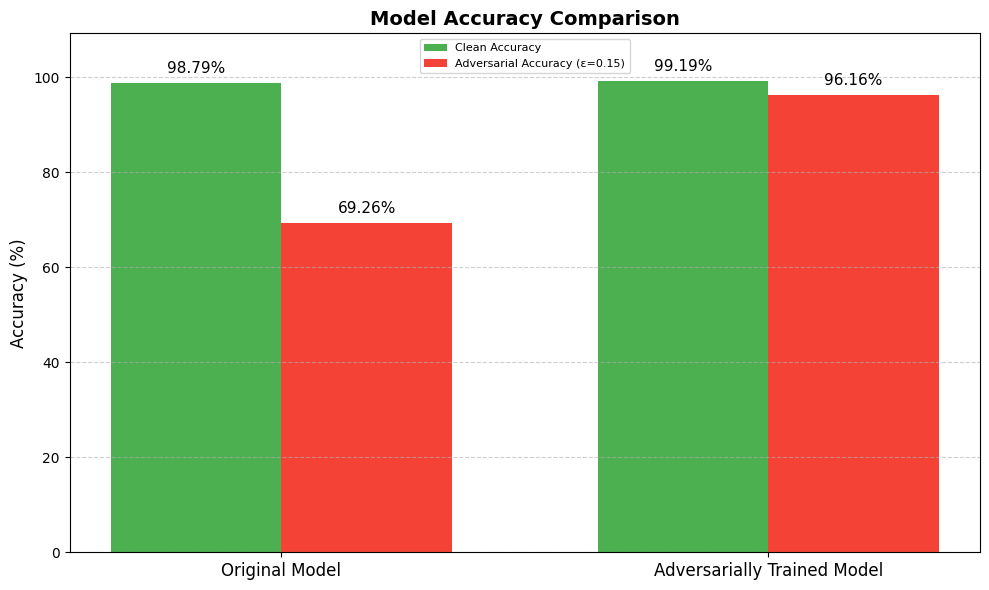

In [37]:
import matplotlib.pyplot as plt
import numpy as np

models = ['Original Model', 'Adversarially Trained Model']
clean_acc = [clean_acc_orig, clean_acc_adv]
adv_acc = [adv_acc_orig, adv_acc_adv]

x = np.arange(len(models))
bar_width = 0.35

plt.figure(figsize=(10, 6))
bar1 = plt.bar(x - bar_width/2, clean_acc, width=bar_width, label='Clean Accuracy', color='#4CAF50')
bar2 = plt.bar(x + bar_width/2, adv_acc, width=bar_width, label='Adversarial Accuracy (ε=0.15)', color='#F44336')

# Formatting
plt.xticks(x, models, fontsize=12)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.title('Model Accuracy Comparison', fontsize=14, weight='bold')
plt.ylim(0, max(clean_acc + adv_acc) + 10)  # Add headroom

# Add grid and legend
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.legend(fontsize=8, loc='best')

# Add bar labels
for bar in bar1 + bar2:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 1.5, f'{height:.2f}%', 
             ha='center', va='bottom', fontsize=11)

plt.tight_layout()
plt.show()
